In [9]:
# --- Your imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import joblib
import kagglehub
from sklearn.metrics import ConfusionMatrixDisplay


In [10]:
# ===================================
# 2. Load Data
# ===================================

# Download dataset
path = kagglehub.dataset_download("arnabbiswas1/microsoft-azure-predictive-maintenance")
print("Path to dataset files:", path)

# Load CSVs
errors = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_errors.csv')
failures = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_failures.csv')
machines = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_machines.csv')
maint = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_maint.csv')
telemetry = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_telemetry.csv')

# Display some data
print('Telemetry Data:')
display(telemetry.head())

print('Errors Data:')
display(errors.head())

print('Failures Data:')
display(failures.head())

print('Maintenance Data:')
display(maint.head())

print('Machines Data:')
display(machines.head())

Path to dataset files: /kaggle/input/microsoft-azure-predictive-maintenance
Telemetry Data:


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


Errors Data:


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


Failures Data:


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Maintenance Data:


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


Machines Data:


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [11]:
# ===================================
# 3. Data Preprocessing
# ===================================

# Convert datetime columns
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
errors['datetime'] = pd.to_datetime(errors['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maint['datetime'] = pd.to_datetime(maint['datetime'])

# Aggregate telemetry data over last 3 hours
telemetry_agg = telemetry.groupby('machineID').rolling('3H', on='datetime').mean().reset_index()

# Merge failures into telemetry (for labeling)
data = pd.merge_asof(
    telemetry_agg.sort_values('datetime'),
    failures.sort_values('datetime'),
    by='machineID',
    on='datetime',
    direction='forward'
)

# Create binary target: failure occurred (1) or not (0)
data['failure'] = data['failure'].notnull().astype(int)

# Merge with machine attributes
data = pd.merge(data, machines, on='machineID')

print('Final merged dataset:')
display(data.head())

# Features and target
features = ['volt', 'rotate', 'pressure', 'vibration', 'age', 'model']
target = 'failure'

# One-hot encoding of 'model'
data = pd.get_dummies(data, columns=['model'])

X = data.drop(['datetime', 'machineID', 'failure'], axis=1)
y = data['failure']

print('Feature set:')
display(X.head())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:')
print(X_train_scaled.shape, X_test_scaled.shape)

/tmp/ipykernel_31/3259026649.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  telemetry_agg = telemetry.groupby('machineID').rolling('3H', on='datetime').mean().reset_index()


Final merged dataset:


,machineID,level_1,datetime,pressure,rotate,vibration,volt,failure,model,age
0,1,0,2015-01-01 06:00:00,113.077935,418.504078,45.087686,176.217853,1,model3,18
1,53,455572,2015-01-01 06:00:00,109.235805,420.980061,45.737760,183.084582,1,model3,5
2,99,858578,2015-01-01 06:00:00,110.921131,384.747105,41.944692,168.596133,1,model1,14
3,12,96371,2015-01-01 06:00:00,97.145400,576.923563,47.725909,171.404215,1,model3,9
4,6,43805,2015-01-01 06:00:00,149.003582,492.088420,22.973289,136.878588,0,model3,7


Feature set:


,level_1,pressure,rotate,vibration,volt,age,model_model1,model_model2,model_model3,model_model4
0,0,113.077935,418.504078,45.087686,176.217853,18,False,False,True,False
1,455572,109.235805,420.980061,45.737760,183.084582,5,False,False,True,False
2,858578,110.921131,384.747105,41.944692,168.596133,14,True,False,False,False
3,96371,97.145400,576.923563,47.725909,171.404215,9,False,False,True,False
4,43805,149.003582,492.088420,22.973289,136.878588,7,False,False,True,False


Shapes:
(700880, 10) (175220, 10)


In [12]:
# ===================================
# 4. Model Training Function
# ===================================

def train_model(model_type, X_train_scaled, y_train, X_test_scaled, y_test):
    tf.keras.backend.clear_session()

    input_shape = (X_train_scaled.shape[1], 1)
    X_train_in = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_test_in = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

    model = Sequential()

    if model_type == 'CNN':
        model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'DNN':
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'LSTM':
        from tensorflow.keras.layers import LSTM
        model.add(LSTM(64, input_shape=input_shape))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'CNN_LSTM':
        from tensorflow.keras.layers import LSTM
        model.add(Conv1D(64, 2, activation='relu', input_shape=input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(64))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_in, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test_in, y_test, verbose=0)

    # Predictions
    preds = (model.predict(X_test_in) > 0.5).astype(int)

    return model, history, test_accuracy, test_loss, preds



--- Training CNN ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17522/17522 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.8609 - loss: 0.3775 - val_accuracy: 0.8653 - val_loss: 0.3557
Epoch 2/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8638 - loss: 0.3604 - val_accuracy: 0.8694 - val_loss: 0.3446
Epoch 3/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8697 - loss: 0.3511 - val_accuracy: 0.8741 - val_loss: 0.3416
Epoch 4/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8709 - loss: 0.3470 - val_accuracy: 0.8734 - val_loss: 0.3376
Epoch 5/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8709 - loss: 0.3454 - val_accuracy: 0.8722 - val_loss: 0.3361
Epoch 6/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8734 - loss: 0.3416 - val_accuracy: 0.8775 - val_loss: 0.3317
Epoch 7/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8747 - loss: 0.3390 - val_accuracy: 0.8782 - val_loss: 0.3254
Epoch 8/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8797 - lo

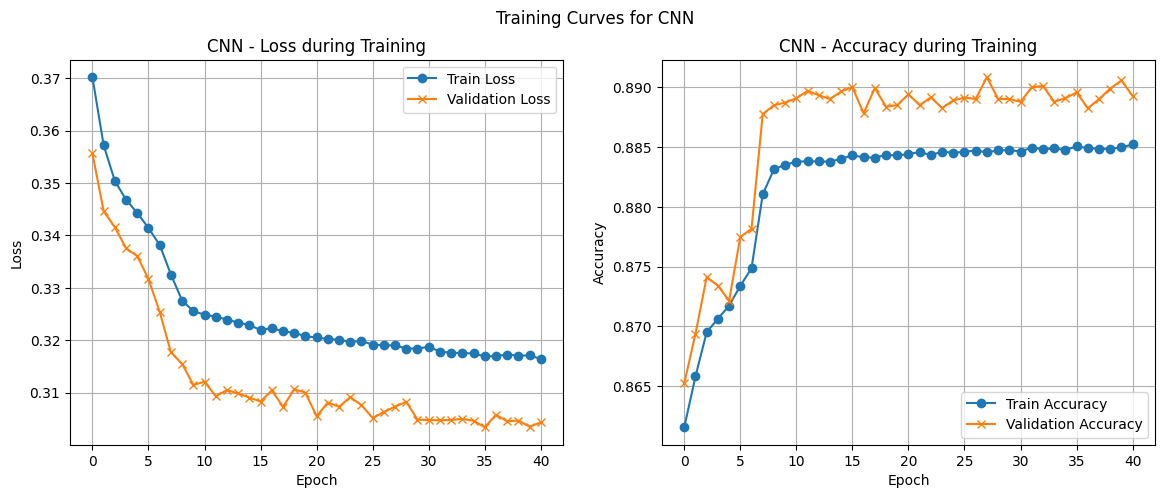

Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.88      0.23      0.36     24044
           1       0.89      1.00      0.94    151176

    accuracy                           0.89    175220
   macro avg       0.89      0.61      0.65    175220
weighted avg       0.89      0.89      0.86    175220



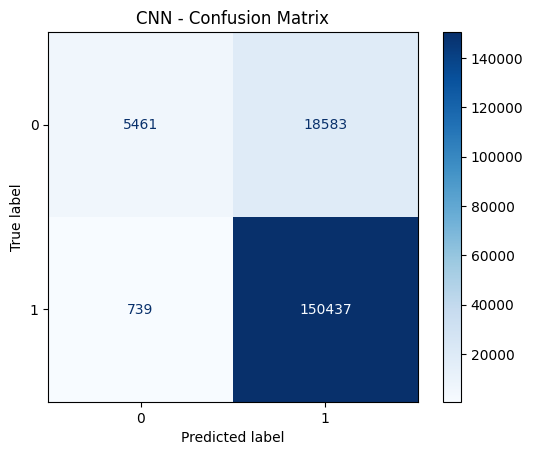


--- Training DNN ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17522/17522 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - accuracy: 0.8698 - loss: 0.3607 - val_accuracy: 0.8886 - val_loss: 0.3150
Epoch 2/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8857 - loss: 0.3228 - val_accuracy: 0.8876 - val_loss: 0.3082
Epoch 3/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8870 - loss: 0.3149 - val_accuracy: 0.8853 - val_loss: 0.3068
Epoch 4/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8867 - loss: 0.3126 - val_accuracy: 0.8903 - val_loss: 0.2992
Epoch 5/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8868 - loss: 0.3103 - val_accuracy: 0.8896 - val_loss: 0.2985
Epoch 6/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8881 - loss: 0.3086 - val_accuracy: 0.8907 - val_loss: 0.2966
Epoch 7/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8888 - loss: 0.3071 - val_accuracy: 0.8910 - val_loss: 0.2959
Epoch 8/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8873 - lo

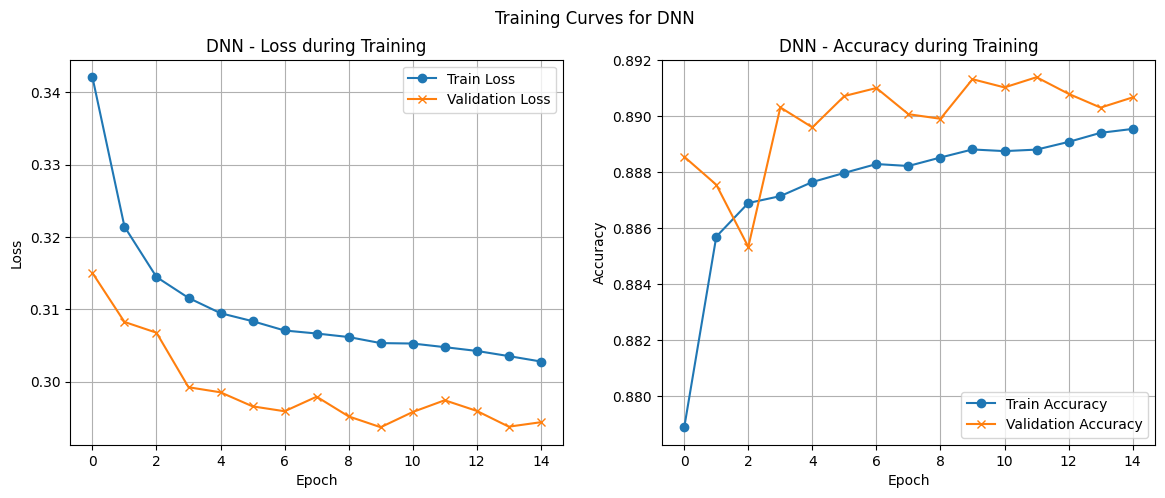

Classification Report for DNN:
              precision    recall  f1-score   support

           0       0.84      0.25      0.38     24044
           1       0.89      0.99      0.94    151176

    accuracy                           0.89    175220
   macro avg       0.87      0.62      0.66    175220
weighted avg       0.89      0.89      0.86    175220



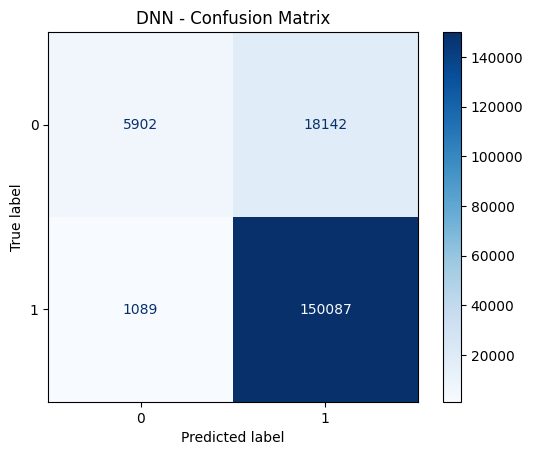


--- Training LSTM ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17522/17522 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.8636 - loss: 0.3801 - val_accuracy: 0.8793 - val_loss: 0.3243
Epoch 2/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.8802 - loss: 0.3234 - val_accuracy: 0.8860 - val_loss: 0.3082
Epoch 3/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.8883 - loss: 0.3037 - val_accuracy: 0.8907 - val_loss: 0.2905
Epoch 4/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.8894 - loss: 0.2964 - val_accuracy: 0.8878 - val_loss: 0.2979
Epoch 5/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.8929 - loss: 0.2875 - val_accuracy: 0.8983 - val_loss: 0.2759
Epoch 6/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.8966 - loss: 0.2763 - val_accuracy: 0.9028 - val_loss: 0.2535
Epoch 7/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.9061 - loss: 0.2503 - val_accuracy: 0.9051 - val_loss: 0.2529
Epoch 8/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.9123 - lo

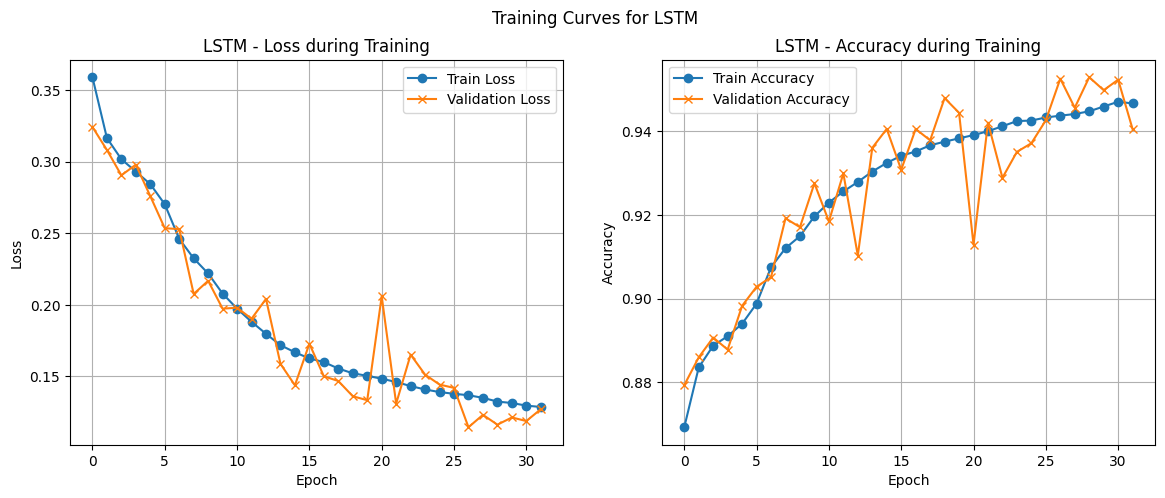

Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     24044
           1       0.97      0.97      0.97    151176

    accuracy                           0.95    175220
   macro avg       0.90      0.90      0.90    175220
weighted avg       0.95      0.95      0.95    175220



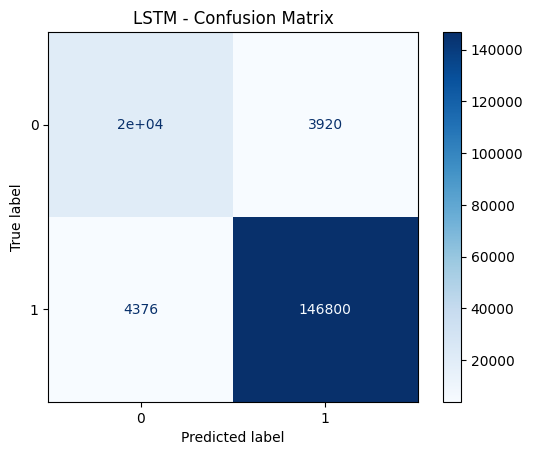


--- Training CNN_LSTM ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17522/17522 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.8657 - loss: 0.3712 - val_accuracy: 0.8770 - val_loss: 0.3307
Epoch 2/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8792 - loss: 0.3295 - val_accuracy: 0.8846 - val_loss: 0.3139
Epoch 3/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8830 - loss: 0.3168 - val_accuracy: 0.8856 - val_loss: 0.3069
Epoch 4/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8847 - loss: 0.3102 - val_accuracy: 0.8875 - val_loss: 0.3067
Epoch 5/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8853 - loss: 0.3079 - val_accuracy: 0.8880 - val_loss: 0.3026
Epoch 6/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8868 - loss: 0.3045 - val_accuracy: 0.8892 - val_loss: 0.3005
Epoch 7/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8880 - loss: 0.3012 - val_accuracy: 0.8861 - val_loss: 0.3034
Epoch 8/50
17522/17522 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8886 - lo

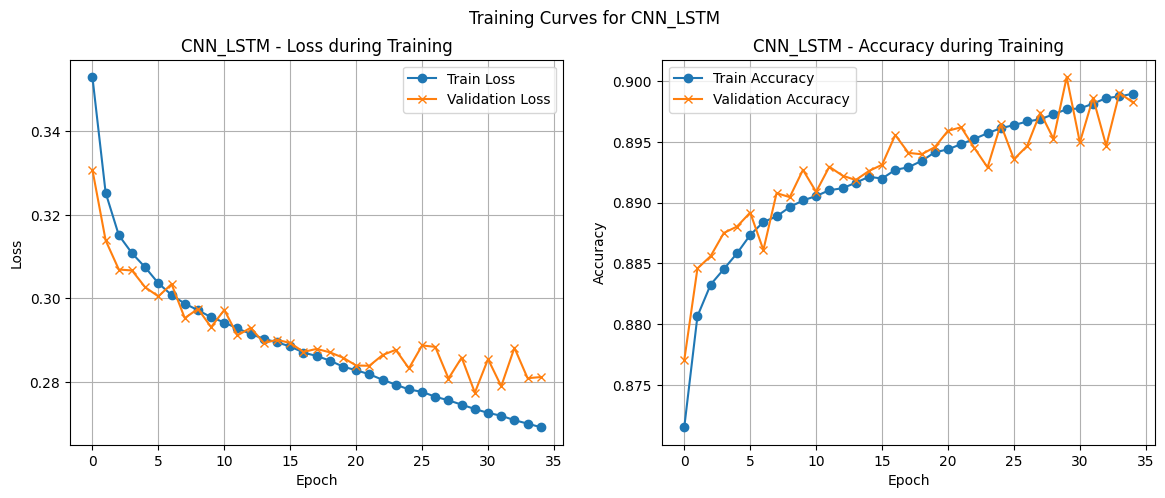

Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.87      0.31      0.46     24044
           1       0.90      0.99      0.94    151176

    accuracy                           0.90    175220
   macro avg       0.89      0.65      0.70    175220
weighted avg       0.90      0.90      0.88    175220



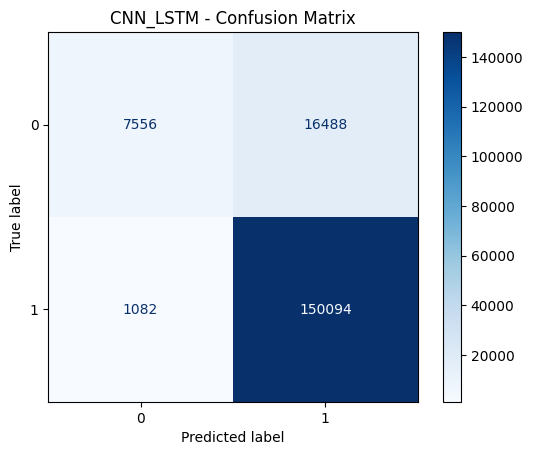

In [13]:
# ===================================
# 5. Train and Evaluate Models
# ===================================

models = ['CNN', 'DNN', 'LSTM', 'CNN_LSTM']
results = {}

for model_type in models:
    print(f"\n--- Training {model_type} ---")
    model, history, acc, loss, preds = train_model(model_type, X_train_scaled, y_train, X_test_scaled, y_test)

    results[model_type] = {
        'model': model,
        'history': history,
        'accuracy': acc,
        'loss': loss,
        'predictions': preds
    }

    # Plot Loss and Accuracy Curves
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(history.history['loss'], label='Train Loss', marker='o')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', marker='x')
    axs[0].set_title(f'{model_type} - Loss during Training')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
    axs[1].set_title(f'{model_type} - Accuracy during Training')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Training Curves for {model_type}")
    plt.show()

    # Confusion Matrix and Classification Report
    print(f"Classification Report for {model_type}:")
    print(classification_report(y_test, results[model_type]['predictions']))

    cm = confusion_matrix(y_test, results[model_type]['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'{model_type} - Confusion Matrix')
    plt.show()

Comparison between models:


,Model,Test Accuracy,Test Loss
0,CNN,0.889727,0.303673
1,DNN,0.890247,0.294833
2,LSTM,0.952654,0.114886
3,CNN_LSTM,0.899726,0.278285


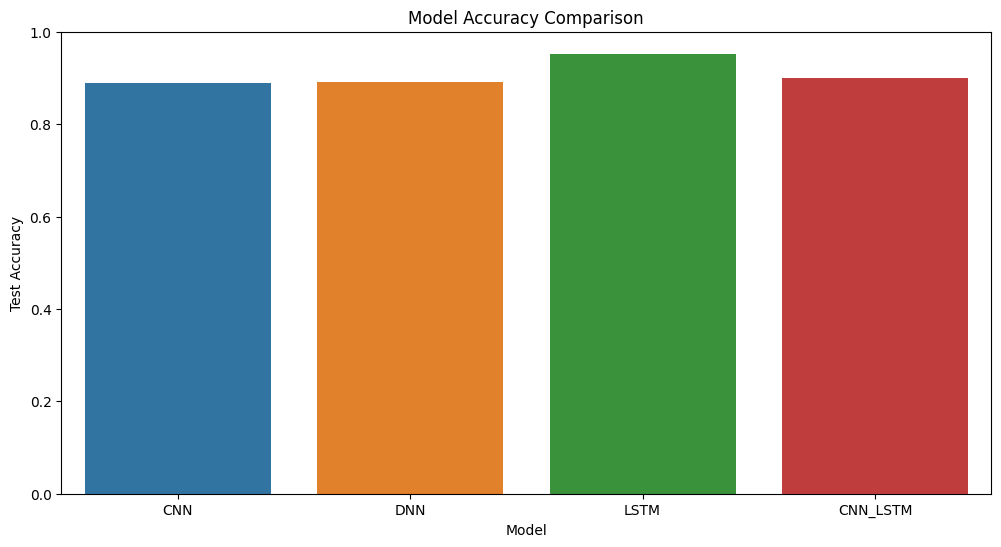

In [14]:
# ===================================
# 6. Summary Results
# ===================================

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['accuracy'] for m in results],
    'Test Loss': [results[m]['loss'] for m in results]
})

print('Comparison between models:')
display(results_df)

plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Test Accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

In [15]:
# Find Best Model
best_model_type = results_df.sort_values('Test Accuracy', ascending=False).iloc[0]['Model']
print(f"Best model is: {best_model_type}")

best_model = results[best_model_type]['model']

# Save Best Model
best_model.save('/kaggle/working/best_model.h5')
joblib.dump(scaler, '/kaggle/working/scaler.pkl')

print('✅ Best model and scaler saved successfully!')

Best model is: LSTM
✅ Best model and scaler saved successfully!



🔎 Additional Testing on Best Model:

Random Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Sample 116556 ➡️  True Label: 1 | Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 97644 ➡️  True Label: 0 | Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample 98197 ➡️  True Label: 0 | Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 23824 ➡️  True Label: 1 | Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 60698 ➡️  True Label: 1 | Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 1232 ➡️  True Label: 1 | Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 139540 ➡️  True Label: 1 | Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 153608 ➡️  True Label: 1 | Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample 169512 ➡️  True Label: 1 | Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 13264 ➡️  True Label: 1 | Predicted Label: 1
5476/5476 ━━━━━━━━━━━━━━━━━━━━ 7

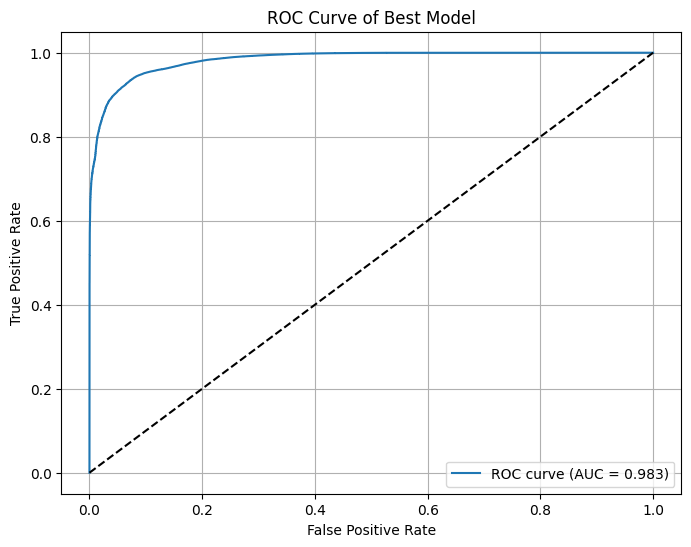

ROC AUC Score: 0.983


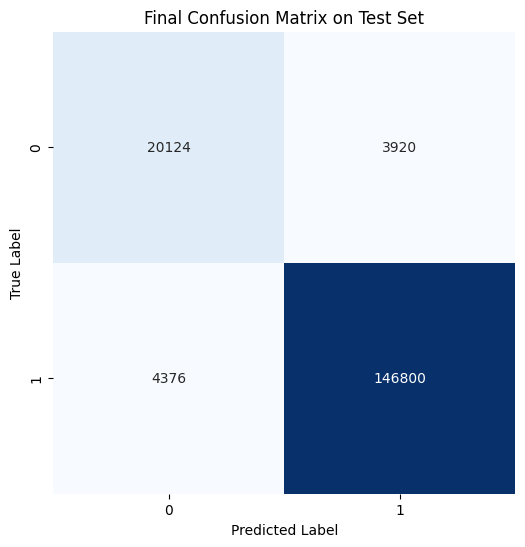


Manual Custom Test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
First Test Sample - True Label: 1, Predicted Label: 1


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
# ===================================
# 7. Extra Testing on Best Model
# ===================================

from sklearn.metrics import roc_curve, roc_auc_score

print("\n🔎 Additional Testing on Best Model:")

# Reload X_test scaled to the correct shape for prediction
X_test_final = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# 1. Random Sample Predictions
n_samples = 10
rand_indices = np.random.choice(len(X_test_scaled), n_samples, replace=False)

print("\nRandom Sample Predictions:")
for idx in rand_indices:
    sample = X_test_scaled[idx].reshape(1, -1, 1)  # Reshape to match input
    true_label = y_test.iloc[idx]
    pred_label = (best_model.predict(sample)[0][0] > 0.5).astype(int)
    print(f"Sample {idx} ➡️  True Label: {true_label} | Predicted Label: {pred_label}")

# 2. ROC Curve and AUC Score
y_pred_probs = best_model.predict(X_test_final).ravel()  # Probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Best Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {auc_score:.3f}")

# 3. Final Confusion Matrix
final_preds = (y_pred_probs > 0.5).astype(int)
cm_final = confusion_matrix(y_test, final_preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', square=True, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Confusion Matrix on Test Set')
plt.show()

# 4. Manual Single Custom Test
print("\nManual Custom Test:")

custom_sample = X_test.iloc[0]  # Take first sample
custom_true = y_test.iloc[0]
custom_sample_scaled = scaler.transform(custom_sample.values.reshape(1, -1))
custom_sample_scaled = custom_sample_scaled.reshape(1, custom_sample_scaled.shape[1], 1)

custom_pred = (best_model.predict(custom_sample_scaled)[0][0] > 0.5).astype(int)

print(f"First Test Sample - True Label: {custom_true}, Predicted Label: {custom_pred}")
